# An Analysis of COVID-19’s Effect on Criminal Activity in Chicago

### Import Packages

In [64]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import pandas as pd
import datetime

### Load DataFrames

In [ ]:
# Chicago crime log from 2001-Present
crimes_raw = pd.read_csv('Crimes_-_2001_to_Present.csv')

# Chicago COVID log
covid = pd.read_csv('COVID-19_Daily_Cases__Deaths__and_Hospitalizations.csv')

### Clean Crimes DataFrame

In [697]:
# drop irrelevant columns
crimes = crimes_raw.drop(columns = ['Case Number', 'IUCR', 'Year', 'Updated On', 'X Coordinate', 'Y Coordinate'])

In [698]:
# change 'Date' column to DateTime format
crimes.insert(2, 'DateTime', pd.to_datetime(crimes['Date']))
# drop old 'Date' column
crimes = crimes.drop(columns = 'Date')
# create new 'Time' column
crimes.insert(2, 'Time', crimes['DateTime'].dt.time)
# create 'Date' column
crimes.insert(2, 'Date', pd.to_datetime(crimes['DateTime'].dt.date))

# sort by date
crimes = crimes.sort_values(by = ['DateTime']).reset_index(drop = True)

# create 'Year' variable 
crimes['Year'] = pd.DatetimeIndex(crimes['Date']).year

# slice DataFrame to only span 2015-2020
crimes = crimes[(crimes['Year'] >= 2015) & (crimes['Year'] < 2021)]

# create 'Month' variable 
crimes['Month'] = pd.DatetimeIndex(crimes['Date']).month

# create 'Year-Month' variable
crimes['Year-Month'] = crimes['Date'].dt.to_period('M')

# combine redundant 'Primary Type' categories
primary_type = []
for typ in crimes['Primary Type']:
    if typ == 'CRIM SEXUAL ASSAULT':
        typ = 'CRIMINAL SEXUAL ASSAULT'
    elif typ == 'OTHER NARCOTIC VIOLATION':
        typ = 'NARCOTICS'
    else:
        typ = typ
    primary_type.append(typ)
crimes['Primary Type'] = primary_type

# create 'Violent Crime' dummy variable from 'FBI Code' variable
crimes['FBI Code'] = pd.to_numeric(crimes['FBI Code'].str.replace('[A-Z]+', ''))
violent_crimes = []
for x in crimes['FBI Code']:
    if x <= 9:
        crime = True
    else:
        crime = False
    violent_crimes.append(crime)
crimes['Violent Crime'] = violent_crimes

In [700]:
# create 'During COVID' dummy variable that indicates whether the crime took place during COVID
def covid_conditions(df):
    if (df['Year'] == 2020) and (df['Month'] >= 3):
        return True
    else:
        return False
    
crimes['During COVID'] = crimes.apply(covid_conditions, axis=1)

In [702]:
# these columns are entered by humans and have too many redundancies to contribute to analysis
# however, they do provide interesting information on the crime
crimes['Description'].value_counts()
crimes['Location Description'].value_counts()

# there are too many 'Beat' categories to substantively contribute to analysis
crimes['Beat'].value_counts()
crimes = crimes.drop(columns = ['Beat', 'Description', 'Location Description', 'Latitude', 'Longitude', 'Time'])

In [704]:
# check NA values
crimes.isnull().any(axis=0)
crimes['Ward'].isnull().sum() #11
crimes['Community Area'].isnull().sum() #1
crimes['Location'].isnull().sum() #1747

20645

- number of NA values for each column is minimal relative to size of dataset.

In [705]:
crimes

,ID,DateTime,Date,Block,Primary Type,Arrest,Domestic,District,Ward,Community Area,FBI Code,Location,Year,Month,Year-Month,Violent Crime,During COVID
5718179,11357023,2015-01-01 00:00:00,2015-01-01,050XX N KENMORE AVE,DECEPTIVE PRACTICE,False,False,20.0,48.0,3.0,11,NaN,2015,1,2015-01,False,False
5718180,10328772,2015-01-01 00:00:00,2015-01-01,037XX N RICHMOND ST,OFFENSE INVOLVING CHILDREN,True,False,17.0,33.0,16.0,17,"(41.949185407, -87.70177312)",2015,1,2015-01,False,False
5718181,12275387,2015-01-01 00:00:00,2015-01-01,050XX S MARSHFIELD AVE,DECEPTIVE PRACTICE,False,False,9.0,20.0,61.0,11,NaN,2015,1,2015-01,False,False
5718182,9912157,2015-01-01 00:00:00,2015-01-01,089XX S WALLACE ST,DECEPTIVE PRACTICE,False,False,22.0,21.0,71.0,11,"(41.732051491, -87.638640464)",2015,1,2015-01,False,False
5718183,9963311,2015-01-01 00:00:00,2015-01-01,054XX S INDIANA AVE,OFFENSE INVOLVING CHILDREN,False,False,2.0,3.0,40.0,26,"(41.79565153, -87.620868294)",2015,1,2015-01,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7260011,12258623,2020-12-31 23:45:00,2020-12-31,056XX S WABASH AVE,BATTERY,False,True,2.0,20.0,40.0,8,"(41.792043078, -87.624017919)",2020,12,2020-12,True,True
7260012,12274737,2020-12-31 23:45:00,2020-12-31,001XX E WACKER DR,THEFT,False,False,1.0,42.0,32.0,6,"(41.888165132, -87.622937212)",2020,12,2020-12,True,True
7260013,12259610,2020-12-31 23:45:00,2020-12-31,002XX E MARQUETTE RD,CRIMINAL DAMAGE,False,False,3.0,6.0,69.0,14,"(41.772893757, -87.619639151)",2020,12,2020-12,False,True
7260014,12258658,2020-12-31 23:51:00,2020-12-31,013XX S HOMAN AVE,BATTERY,False,False,10.0,24.0,29.0,4,"(41.863406877, -87.710455868)",2020,12,2020-12,True,True


### Clean Covid DataFrame

In [518]:
# change 'Date' column to DateTime format
covid['Date'] = pd.to_datetime(covid['Date'])

# sort by date
# delete rows with missing data due to ongoing collection of recent information (previous week)
covid = covid.sort_values(by = ['Date']).reset_index(drop = True).iloc[:362, :]

#covid

### Merge Covid and Crimes DataFrames

In [880]:
crime_counts = crimes.groupby('Date').count().ID
crime_counts = covid.merge(crime_counts.to_frame(), on = 'Date', how = 'right').rename(columns = {'ID': '# of crimes'})
crime_counts = crime_counts[['Date', 'Cases - Total', '# of crimes']].sort_values('Date')
crime_counts

,Date,Cases - Total,# of crimes
306,2015-01-01,NaN,1220
307,2015-01-02,NaN,673
308,2015-01-03,NaN,648
309,2015-01-04,NaN,514
310,2015-01-05,NaN,523
...,...,...,...
301,2020-12-27,621.0,492
302,2020-12-28,1660.0,521
303,2020-12-29,1713.0,424
304,2020-12-30,1442.0,466


# ANALYSIS

### Functions:

In [809]:
def grouped_crimes_per_month(df, column, group_label = 'Shuffled'):
    crimes = df.groupby(group_label).sum()[column].to_frame().reset_index()
    months = df.groupby(group_label).nunique()['Year-Month'].to_frame().reset_index()
    grouped = pd.merge(crimes, months, on = group_label).set_index(group_label)
    grouped['Crimes per Month'] = round((grouped[column] / grouped['Year-Month']), 2)
    grouped = grouped['Crimes per Month']
    return grouped

In [810]:
# returns the difference of average monthly crimes between groups
def difference_of_means(grouped_table):
    return round(grouped_table[0] - grouped_table[1], 2)

In [811]:
def one_simulated_difference(df, column):
    shuffled_labels = list(hypothesis['During COVID'].sample(frac = 1))
    df['Shuffled'] = shuffled_labels
    grouped_table = grouped_crimes_per_month(df, column)
    return difference_of_means(grouped_table)

In [825]:
def bootstrap_mean(df, column, replications):
    
    """Returns an array of bootstrapped sample means:
    df: table containing the original sample
    group_label: label of column containing the variable
    replications: number of bootstrap samples
    """
    
    #just_one_column = df['During COVID']
    means = make_array()
    for i in np.arange(replications):
        difference = one_simulated_difference(df, column)
        means = np.append(means, difference)
        
    return means

In [813]:
# Robust Squared Error (removes largest outlier)
def line_rse(x,y):
    if len(x)!=len(y):
        raise ValueError('arrays are of different lengths')
    def rse(any_slope, any_intercept):
        estimate = any_slope*x + any_intercept
        return (np.sum((y - estimate) ** 2) - np.max((y - estimate) ** 2)) 
    return minimize(rse, method = "CG") 

In [814]:
def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x))/np.std(x,ddof=1)  

def correlation(x, y):
    x_in_standard_units = standard_units(x)
    y_in_standard_units = standard_units(y)
    if len(x)!=len(y):
        raise ValueError('arrays are of different lengths')
    return sum(x_in_standard_units * y_in_standard_units)/(len(x)-1)

def slope(x, y):
    if len(x)!=len(y):
        raise ValueError('arrays are of different lengths')
    return  correlation(x, y)* np.std(y,ddof=1)/np.std(x,ddof=1)

# outputs a 95% CI for the slope
# input is a data frame, the name of the two columns, and # of bootstraps
def bootstrap_slope(df, x, y, repetitions):
    # the number of observations
    n = df.shape[0]
    # Bootstrap the scatter, find the slope, collect
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = df.sample(n,replace = True)
        bootstrap_slope = slope(bootstrap_sample[x], bootstrap_sample[y])
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(df[x],df[y])
    
    # Display results
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the slope of the true line:')
    print(left, 'to', right)

In [1046]:
def df_for_hypothesis(column, totals = False):
    
    if totals == False:
        hypothesis_df = crimes[['Year-Month', 'During COVID', column]]
        hypothesis_df = hypothesis_df[hypothesis_df[column] == True]
    else:
        hypothesis_df = crimes
    
    during_covid_indicator = crimes.groupby('Year-Month').sum()['During COVID'].to_frame().reset_index()
    during = []
    for x in during_covid_indicator['During COVID']:
        if x > 0:
            x = True
        else:
            x = False
        during.append(x)
    during_covid_indicator['During COVID'] = during
    hypothesis_df = pd.DataFrame(hypothesis_df.groupby('Year-Month').count()[column]).reset_index()
    hypothesis_df = pd.merge(hypothesis_df, during_covid_indicator, on = 'Year-Month')
    
    # random permutations of 'During COVID' column
    shuffled_labels = list(hypothesis_df['During COVID'].sample(frac = 1))
    hypothesis_df['Shuffled'] = shuffled_labels
    
    return hypothesis_df


def differences_array(df, column, totals = False):
    
    hypothesis_df = df_for_hypothesis(column, totals)

    differences = make_array()
    repetitions = 1000
    for i in np.arange(repetitions):
        new_difference = one_simulated_difference(df, column)
        differences = np.append(differences, new_difference)
    
    return differences


def CI_bounds(column, totals):
    
    hypothesis_df = df_for_hypothesis(column, totals)

    means = bootstrap_mean(hypothesis_df, column, 1000)
    left = percentile(2.5, means)
    right = percentile(97.5, means)
    
    return left, right


def hypothesis_test(df, column, totals = False):
    
    observed = grouped_crimes_per_month(df, column, group_label = 'During COVID')
    observed_difference = difference_of_means(observed)
    
    repetitions = 1000
    differences = differences_array(df, column, totals)
    
    #p_value = np.count_nonzero(differences <= observed_difference) / repetitions
    
    left = CI_bounds(column, totals)[0]
    right = CI_bounds(column, totals)[1]

    print('Observed Difference in crimes per month between pre/post-COVID groups', observed_difference)
    print('95% Confidence Interval: (', left, ',', right, ')')
    #print('p-value =', p_value)
    
    
def hypothesis_plot(df, column, totals = False):

    differences = differences_array(df, column, totals)
    
    observed = grouped_crimes_per_month(df, column, group_label = 'During COVID')
    observed_difference = difference_of_means(observed)

    data = {'Difference Between\n Group Means': differences}
    means_diff_df = pd.DataFrame(data)
    means_diff_df.plot.hist()
    
    left = CI_bounds(column, totals)[0]
    right = CI_bounds(column, totals)[1]

    # 95% Confidence Interval
    plots.plot(make_array(left, right), make_array(0, 0), color = 'yellow', lw = 8)
    
    # observed difference marker
    plots.scatter(observed_difference, -10, color = 'red', s = 60, zorder = 1, label = 'Observed Difference');

    plots.legend(handletextpad = 1, handlelength = 1, fontsize = 10);

### Question: Did domestic criminal activity change during COVID?

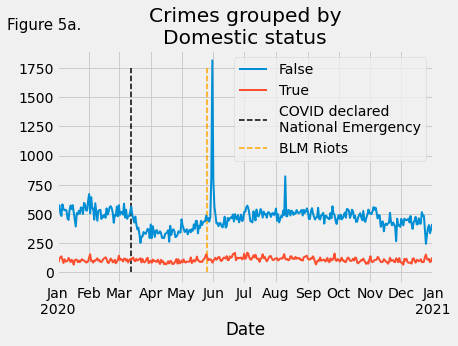

In [1085]:
crimes.groupby(['Date', 'Domestic'])['ID'] \
      .count().unstack('Domestic').plot.line(linewidth = 2)

plots.axis(xmin = pd.to_datetime('2020-01-01'), xmax = pd.to_datetime('2021-01-01'));
plots.vlines(x = '2020-03-13', ymin = 0, ymax = 1750, linestyle = 'dashed',
             color = 'black',
             label = 'COVID declared\nNational Emergency',
             linewidth = 1.5);
plots.vlines(x = '2020-05-26', ymin = 0, ymax = 1750, linestyle = 'dashed',
             color = 'orange',
             label = 'BLM Riots',
             linewidth = 1.5);

plots.legend();

plots.title('Crimes grouped by\nDomestic status');

plots.figtext(.05, .95, 'Figure 5a.', ha='center', size = 15);

In [ ]:
domestic_df = df_for_hypothesis('Domestic')
domestic_df

In [1029]:
domestic_observed = grouped_crimes_per_month(domestic_df, 'Domestic', 'During COVID').to_frame()
domestic_observed

,Crimes per Month
During COVID,
False,3568.48
True,3334.30


In [850]:
hypothesis_test(domestic_df, 'Domestic')

Observed Difference in crimes per month between pre/post-COVID groups 234.18
95% Confidence Interval: ( -244.38 , 250.91 )


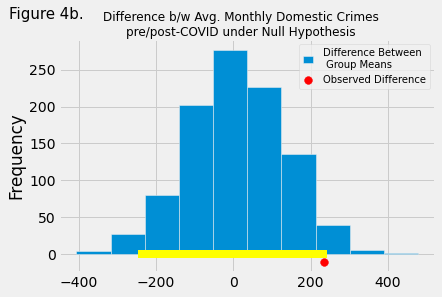

In [1083]:
hypothesis_plot(domestic_df, 'Domestic')
plots.suptitle('Difference b/w Avg. Monthly Domestic Crimes\npre/post-COVID under Null Hypothesis', size = 12);
plots.figtext(.05, .95, 'Figure 4b.', ha = 'center', size = 15);

### Question: Did the frequency of arrests change during COVID?

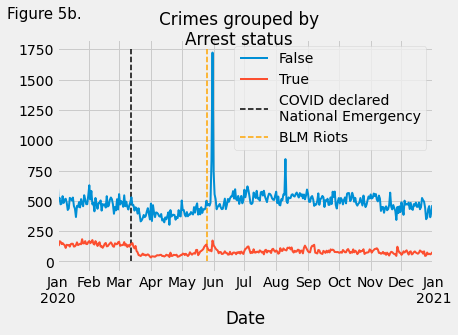

In [1087]:
crimes.groupby(['Date', 'Arrest'])['ID'] \
      .count().unstack('Arrest').plot.line(linewidth = 2)

plots.vlines(x = '2020-03-13', ymin = 0, ymax = 1750, linestyle = 'dashed',
             color = 'black',
             label = 'COVID declared\nNational Emergency',
             linewidth = 1.5);
plots.vlines(x = '2020-05-26', ymin = 0, ymax = 1750, linestyle = 'dashed',
             color = 'orange',
             label = 'BLM Riots',
             linewidth = 1.5);

plots.legend();

plots.suptitle('Crimes grouped by\nArrest status');

plots.axis(xmin = pd.to_datetime('2020-01-01'), xmax = pd.to_datetime('2021-01-01'));
plots.figtext(.05, .95, 'Figure 5b.', ha='center', size = 15);

In [855]:
arrest_df = df_for_hypothesis('Arrest')
arrest_df

,Year-Month,Arrest,During COVID,Shuffled
0,2015-01,6180,False,False
1,2015-02,5154,False,False
2,2015-03,6601,False,False
3,2015-04,5956,False,False
4,2015-05,6311,False,False
...,...,...,...,...
67,2020-08,2916,True,False
68,2020-09,2606,True,True
69,2020-10,2514,True,True
70,2020-11,2307,True,False


In [1030]:
arrest_observed = grouped_crimes_per_month(arrest_df, 'Arrest', 'During COVID').to_frame()
arrest_observed

,Crimes per Month
During COVID,
False,4741.71
True,2465.30


In [857]:
hypothesis_test(arrest_df, 'Arrest')

Observed Difference in crimes per month between pre/post-COVID groups 2276.41
95% Confidence Interval: ( -641.56 , 762.9 )


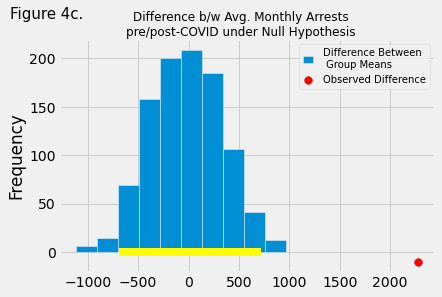

In [1084]:
hypothesis_plot(arrest_df, 'Arrest')
plots.suptitle('Difference b/w Avg. Monthly Arrests\npre/post-COVID under Null Hypothesis', size = 12);
plots.figtext(.05, .95, 'Figure 4c.', ha = 'center', size = 15);

### Question: Did frequency of violent crime/non-violent crime change during COVID?

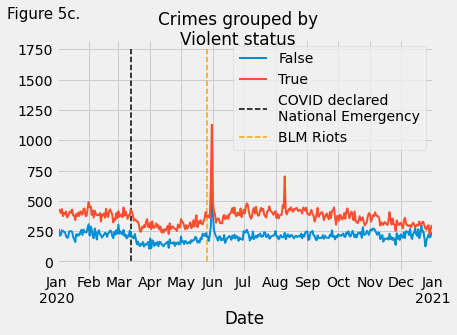

In [1088]:
crimes.groupby(['Date', 'Violent Crime'])['ID'] \
      .count().unstack('Violent Crime').plot.line(linewidth = 2)

plots.vlines(x = '2020-03-13', ymin = 0, ymax = 1750, linestyle = 'dashed',
             color = 'black',
             label = 'COVID declared\nNational Emergency',
             linewidth = 1.5);
plots.vlines(x = '2020-05-26', ymin = 0, ymax = 1750, linestyle = 'dashed',
             color = 'orange',
             label = 'BLM Riots',
             linewidth = 1.5);

plots.legend();

plots.suptitle('Crimes grouped by\nViolent status');
plots.figtext(.05, .95, 'Figure 5c.', ha='center', size = 15);

plots.axis(xmin = pd.to_datetime('2020-01-01'), xmax = pd.to_datetime('2021-01-01'));

In [860]:
violent_df = df_for_hypothesis('Violent Crime')
violent_df

,Year-Month,Violent Crime,During COVID,Shuffled
0,2015-01,12122,False,False
1,2015-02,9104,False,True
2,2015-03,12304,False,True
3,2015-04,12573,False,False
4,2015-05,14398,False,False
...,...,...,...,...
67,2020-08,13193,True,False
68,2020-09,11538,True,False
69,2020-10,11261,True,False
70,2020-11,10079,True,False


In [1031]:
violent_observed = grouped_crimes_per_month(violent_df, 'Violent Crime', 'During COVID').to_frame()
violent_observed

,Crimes per Month
During COVID,
False,13916.21
True,10984.10


In [862]:
hypothesis_test(violent_df, 'Violent Crime')

Observed Difference in crimes per month between pre/post-COVID groups 2932.11
95% Confidence Interval: ( -1152.85 , 1262.17 )


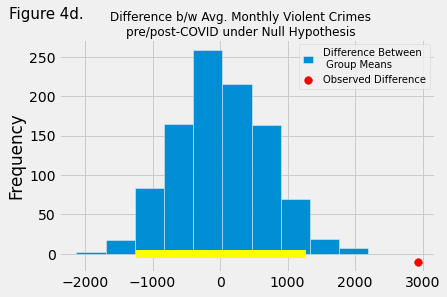

In [1089]:
hypothesis_plot(violent_df, 'Violent Crime')
plots.suptitle('Difference b/w Avg. Monthly Violent Crimes\npre/post-COVID under Null Hypothesis', size = 12);
plots.figtext(.05, .95, 'Figure 4d.', ha = 'center', size = 15);

In [998]:
crime_counts

,Date,Cases - Total,# of crimes
306,2015-01-01,NaN,1220
307,2015-01-02,NaN,673
308,2015-01-03,NaN,648
309,2015-01-04,NaN,514
310,2015-01-05,NaN,523
...,...,...,...
301,2020-12-27,621.0,492
302,2020-12-28,1660.0,521
303,2020-12-29,1713.0,424
304,2020-12-30,1442.0,466


### Question: Did frequency of total crime change during COVID?

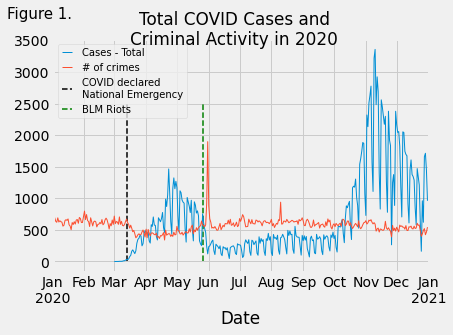

In [1090]:
crime_counts.plot(kind = 'line', x = 'Date', y = ['Cases - Total', '# of crimes'], linewidth = 1)

plots.vlines(x = '2020-03-13', ymin = 0, ymax = 2500, linestyle = 'dashed',
             color = 'black',
             label = 'COVID declared\nNational Emergency',
             linewidth = 1.5);
plots.vlines(x = '2020-05-26', ymin = 0, ymax = 2500, linestyle = 'dashed',
             color = 'green',
             label = 'BLM Riots',
             linewidth = 1.5);

plots.legend(handletextpad = 1, handlelength = 1, fontsize = 10);

plots.axis(xmin = pd.to_datetime('2020-01-01'), xmax = pd.to_datetime('2021-01-01'))

plots.suptitle('Total COVID Cases and\nCriminal Activity in 2020');

plots.figtext(.05, .95,'Figure 1.', ha='center', size = 15);

plots.show()

- number of crimes dips when quarantine starts
- crimes and cases rise together as people stray from lockdown

In [1079]:
# crime distribution by month for 2017-2019
crime_distr_2015_19 = crimes[(crimes['Year'] >= 2015) & (crimes['Year'] < 2020)].groupby(['Year', 'Month']).count().groupby('Month').ID.mean().to_frame().reset_index().sort_values('Month')
dates = []
for x in crime_distr_2015_19['Month']:
    x = str(x)
    datetime_object = datetime.strptime(x, "%m")
    month_name = datetime_object.strftime("%b")
    dates.append(month_name)
crime_distr_2015_19['Month'] = dates

crime_distr_2015_19

,Month,ID
0,Jan,20773.8
1,Feb,18031.6
2,Mar,21178.2
3,Apr,21335.8
4,May,23787.6
5,Jun,23775.6
6,Jul,24800.0
7,Aug,24848.4
8,Sep,23024.8
9,Oct,22842.0


In [962]:
# crime distribution by month for 2020
crime_distr_2020 = crimes[crimes['Year'] == 2020].groupby(['Year', 'Month']).count().ID.to_frame().reset_index()
dates = []
for x in crime_distr_2020['Month']:
    x = str(x)
    datetime_object = datetime.strptime(x, "%m")
    month_name = datetime_object.strftime("%b")
    dates.append(month_name)
crime_distr_2020['Month'] = dates

crime_distr_2020

,Year,Month,ID
0,2020,Jan,19768
1,2020,Feb,18124
2,2020,Mar,16635
3,2020,Apr,12821
4,2020,May,17512
5,2020,Jun,17515
6,2020,Jul,19446
7,2020,Aug,19735
8,2020,Sep,17762
9,2020,Oct,18248


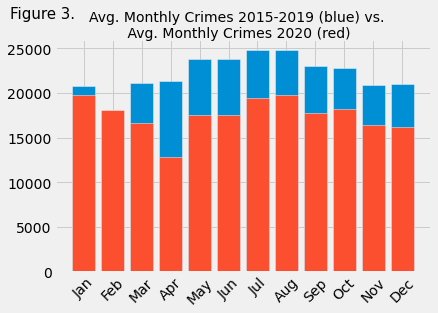

In [1107]:
# plot of the average monthly crimes from 2017-2019 in red
# and the monthly crimes from 2020 in blue

plots.bar(crime_distr_2015_19['Month'], height = crime_distr_2015_19['ID']);
plots.bar(crime_distr_2020['Month'], height = crime_distr_2020['ID']);

plots.xticks(rotation = 45);

plots.suptitle('Avg. Monthly Crimes 2015-2019 (blue) vs.\n Avg. Monthly Crimes 2020 (red)', size = 14);

plots.figtext(.05, .95, 'Figure 3.', ha='center', size = 15);

### Hypothesis Test for Difference in Means of Criminal Activity (on a per-month basis) between pre-COVID and post-COVID

Null Hypothesis: The frequency of criminal activity in Chicago on a per-month basis is the same for pre-COVID as for post-COVID. The difference in the sample is due to chance.

Alternative Hypothesis: Criminal activity in Chicago was more frequent pre-COVID, on average, than post-COVID.

In [752]:
during_covid_df = df_for_hypothesis('ID', totals = True)
during_covid_df

,Year-Month,ID,During COVID,Shuffled
0,2015-01,20922,False,False
1,2015-02,16389,False,False
2,2015-03,21672,False,False
3,2015-04,21718,False,False
4,2015-05,23696,False,False
...,...,...,...,...
67,2020-08,19735,True,False
68,2020-09,17762,True,False
69,2020-10,18248,True,False
70,2020-11,16399,True,True


In [753]:
# check if value counts are the same for original and shuffled columns
print(during_covid_df['During COVID'].value_counts())
print(during_covid_df['Shuffled'].value_counts())

False    62
True     10
Name: During COVID, dtype: int64
False    62
True     10
Name: Shuffled, dtype: int64


In [754]:
observed = grouped_crimes_per_month(during_covid_df, 'ID')
observed

During COVID
False    22089.92
True     17226.20
Name: Crimes per Month, dtype: float64

In [874]:
hypothesis_test(during_covid_df, 'ID', totals = 'True')

Observed Difference in crimes per month between pre/post-COVID groups 4863.72
95% Confidence Interval: ( -1659.02 , 1960.15 )


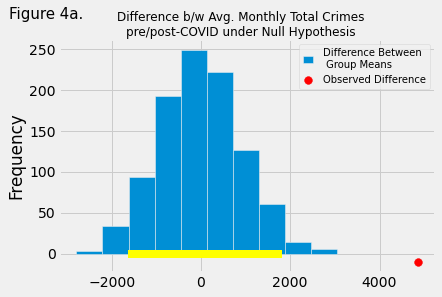

In [1081]:
hypothesis_plot(during_covid_df, 'ID', totals = 'True');
plots.suptitle('Difference b/w Avg. Monthly Total Crimes\npre/post-COVID under Null Hypothesis', size = 12);
plots.figtext(.05, .95, 'Figure 4a.', ha = 'center', size = 15);

- the observed difference is outside the 95% confidence interval and has a p-value of 1.0 from the simulation
- thus, there is an excess of evidence that criminal activity in Chicago during the covid era is less than pre-COVID

### Question: Are daily criminal activity and daily COVID cases related?

In [585]:
crime_counts = crime_counts[(crime_counts['Date'] >= '2020-03-21') & (crime_counts['Date'] < '2021-01-01')]
#crime_counts

Slope: -0.027 , Intercept: 577.318


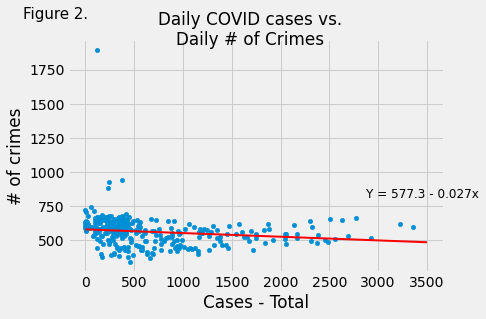

In [1095]:
print("Slope:", round(line_rse(crime_counts['Cases - Total'], crime_counts['# of crimes'])[0], 3),
      ", Intercept:", round(line_rse(crime_counts['Cases - Total'], crime_counts['# of crimes'])[1], 3))

xlims = np.array([0, 3500])
crime_counts.plot.scatter(x = 'Cases - Total', y = '# of crimes');
plots.plot(xlims, -0.027 * xlims + 577.306, lw=2, color = 'red');
plots.suptitle('Daily COVID cases vs.\nDaily # of Crimes');

plots.figtext(.05, .95,'Figure 2.', ha='center', size = 15);
plots.figtext(.90, .33,'Y = 577.3 - 0.027x', ha='center', size = 12);


In [593]:
bootstrap_slope(crime_counts, 'Cases - Total', '# of crimes', 500)

Slope of regression line: -0.031202169689600785
Approximate 95%-confidence interval for the slope of the true line:
-0.05326772148900438 to -0.01577488721357722


- used Robust Squared Error because of extreme outlier
- the slope of the regression line is significantly less than zero
- when COVID cases are high, criminal activity in Chicago is expected to decrease

### Random Info

In [551]:
crimes.groupby('Primary Type').count().ID.sort_values(ascending = False)

Primary Type
THEFT                                352103
BATTERY                              289205
CRIMINAL DAMAGE                      168067
ASSAULT                              114338
DECEPTIVE PRACTICE                   110628
OTHER OFFENSE                         98591
NARCOTICS                             84892
BURGLARY                              70576
MOTOR VEHICLE THEFT                   61627
ROBBERY                               59016
CRIMINAL TRESPASS                     37414
WEAPONS VIOLATION                     31717
OFFENSE INVOLVING CHILDREN            13580
PUBLIC PEACE VIOLATION                 9687
CRIMINAL SEXUAL ASSAULT                9114
INTERFERENCE WITH PUBLIC OFFICER       6837
SEX OFFENSE                            6467
PROSTITUTION                           4531
HOMICIDE                               3855
ARSON                                  2745
LIQUOR LAW VIOLATION                   1353
STALKING                               1148
GAMBLING           

In [528]:
means_table = crimes.groupby('During COVID').mean()[['Arrest', 'Domestic', 'Violent Crime']]
means_table

,Arrest,Domestic,Violent Crime
During COVID,,,
False,0.214655,0.161544,0.629980
True,0.143113,0.193560,0.637639
